## TODO:
 - Pipeline
 - Transfer Learning?
 - Plot all models performance
 - Show samples that model got wrong
 - Other success metrics
 - General refactor

In [8]:
import numpy as np
np.random.seed(2020)

import os
import tqdm
import cv2
import pandas as pd
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

## Load Images

In [9]:
def load_images(dir_path, image_list, label_list, label):
    for img in os.listdir(dir_path):
        if img.endswith('.png'):
            image = cv2.imread(dir_path + img)
            image_list.append(image)
            label_list.append(label)

In [11]:
def load_data():
    parasitized = './cell_images/Parasitized/'
    uninfected = './cell_images/Uninfected/'
    
    images = []
    labels = []
    
    load_images(uninfected, images, labels, 0)
    load_images(parasitized, images, labels, 1)
    width, height = get_img_shapes(images)
    
    median_height = np.median(height).astype('int64')
    median_width = np.median(width).astype('int64')
    median_shape = (median_width, median_height)
    
    for idx, image in enumerate(images):
        images[idx] = np.array(Image.fromarray(image, 'RGB').resize(median_shape))
    
    X = np.array(images)
    y = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    if y_train.ndim == 1: y_train = to_categorical(y_train)
    if y_test.ndim == 1: y_test = to_categorical(y_test)
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

# Visualisation

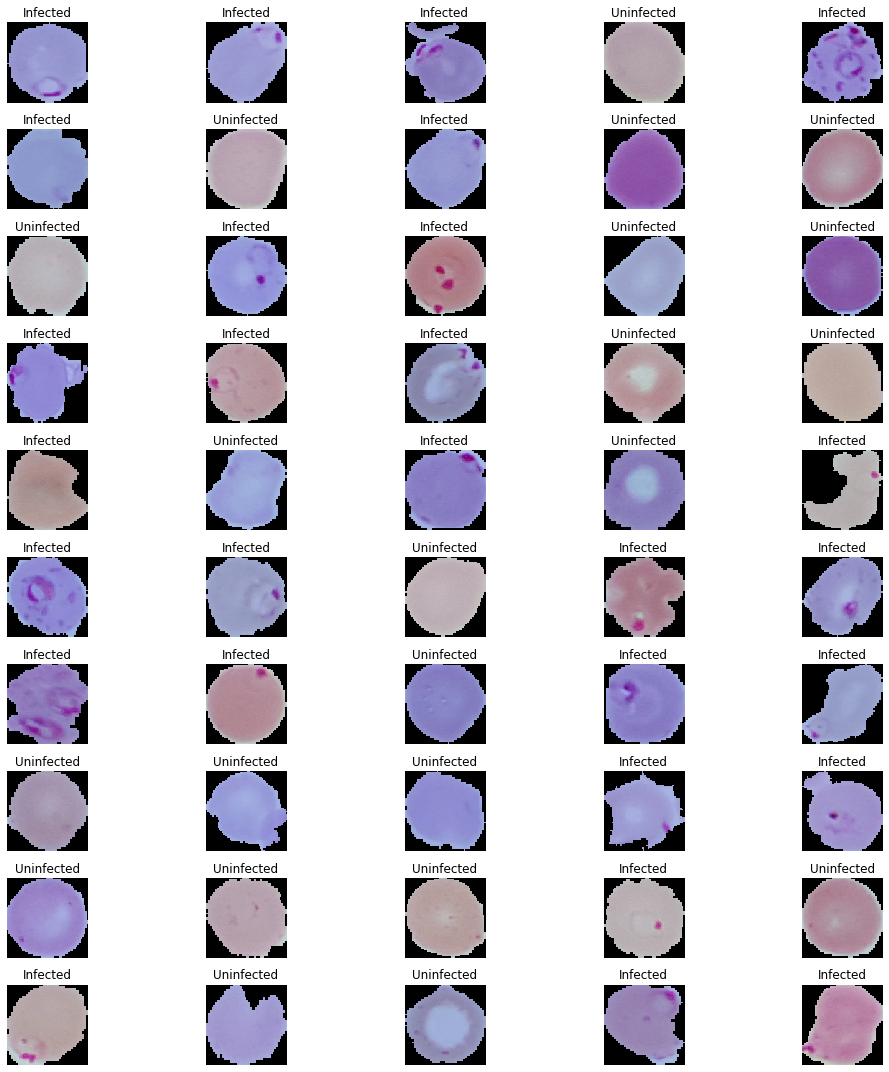

In [104]:
plt.figure(figsize=(15, 15))
for i in range(50):
    random = np.random.randint(0, len(X_train))
    plt.subplot(10, 5, i+1)
    plt.imshow(X_train[random])
    plt.title('Infected' if y_train[random][1] == 1 else 'Uninfected')
    plt.axis('off')
    
plt.tight_layout()

## Simple CNN

In [12]:
def plot_loss(history, key='acc'):
    plt.figure(figsize=(15, 5))
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [13]:
input_shape = X_train[0].shape

In [107]:
input_shape

(130, 130, 3)

In [108]:
basic_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
basic_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 15)        0         
_______________________________________

In [43]:
basic_history = basic_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 159s 8ms/sample - loss: 0.6630 - acc: 0.6017 - val_loss: 0.6212 - val_acc: 0.6693
Epoch 2/10
19290/19290 [==============================] - 156s 8ms/sample - loss: 0.5547 - acc: 0.7201 - val_loss: 0.5004 - val_acc: 0.7522
Epoch 3/10
19290/19290 [==============================] - 151s 8ms/sample - loss: 0.4084 - acc: 0.8138 - val_loss: 0.3188 - val_acc: 0.8661
Epoch 4/10
19290/19290 [==============================] - 197s 10ms/sample - loss: 0.2606 - acc: 0.8958 - val_loss: 0.2885 - val_acc: 0.8990
Epoch 5/10
19290/19290 [==============================] - 216s 11ms/sample - loss: 0.2244 - acc: 0.9145 - val_loss: 0.2247 - val_acc: 0.9192
Epoch 6/10
19290/19290 [==============================] - 212s 11ms/sample - loss: 0.1759 - acc: 0.9365 - val_loss: 0.2006 - val_acc: 0.9279
Epoch 7/10
19290/19290 [==============================] - 165s 9ms/sample - loss: 0.1473 - acc: 0.9448 - val

In [44]:
basic_score = basic_model.evaluate(X_test, y_test)

8268/8268 [==============================] - 43s 5ms/sample - loss: 0.1829 - acc: 0.9380


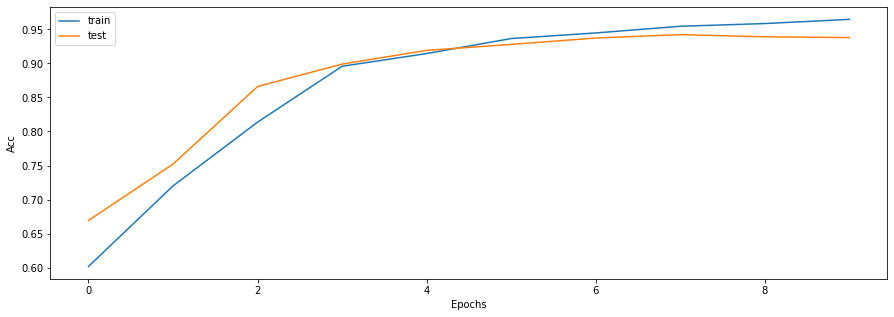

In [47]:
plot_loss(basic_history)

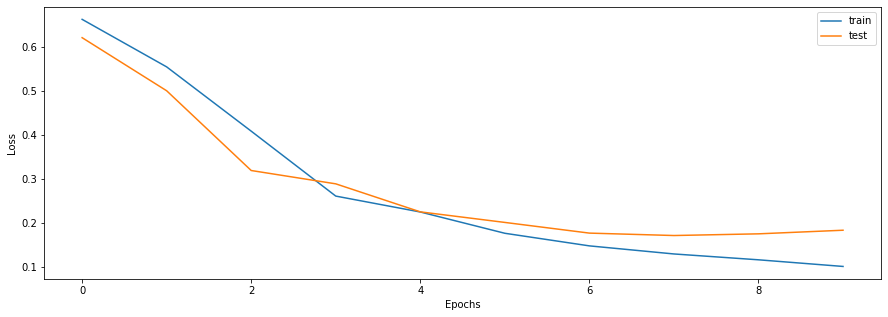

In [48]:
plot_loss(basic_history, key='loss')

## Adding dropout on fully connected layers

In [91]:
dropout_model = Sequential([
    Conv2D(filters={{ quniform(3, 30) }}, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters={{ quniform(3, 30) }}, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters={{ quniform(3, 30) }}, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters={{ quniform(3, 30) }}, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense({{ choice([64, 128, 256, 512, 1024]) }}, activation='relu'),
    Dropout({{ uniform(0, 1) }}),
    Dense({{ choice([64, 128, 256, 512, 1024]) }}, activation='relu'),
    Dropout({{ uniform(0, 1) }}),
    Dense({{ choice([64, 128, 256, 512, 1024]) }}, activation='relu'),
    Dropout({{ uniform(0, 1) }}),
    Dense({{ choice([64, 128, 256, 512, 1024]) }}, activation='relu'),
    Dense(2, activation='softmax')
])
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dropout_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 15)      

In [92]:
dropout_history = dropout_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 163s 8ms/sample - loss: 2.7343 - acc: 0.5077 - val_loss: 0.6825 - val_acc: 0.5417
Epoch 2/10
19290/19290 [==============================] - 138s 7ms/sample - loss: 0.6705 - acc: 0.5852 - val_loss: 0.6334 - val_acc: 0.6366
Epoch 3/10
19290/19290 [==============================] - 135s 7ms/sample - loss: 0.6442 - acc: 0.6232 - val_loss: 0.6065 - val_acc: 0.6534
Epoch 4/10
19290/19290 [==============================] - 136s 7ms/sample - loss: 0.5623 - acc: 0.7101 - val_loss: 0.4721 - val_acc: 0.7649
Epoch 5/10
19290/19290 [==============================] - 136s 7ms/sample - loss: 0.3675 - acc: 0.8368 - val_loss: 0.2337 - val_acc: 0.9107
Epoch 6/10
19290/19290 [==============================] - 134s 7ms/sample - loss: 0.2138 - acc: 0.9214 - val_loss: 0.1769 - val_acc: 0.9338
Epoch 7/10
19290/19290 [==============================] - 136s 7ms/sample - loss: 0.1610 - acc: 0.9441 - val_lo

In [93]:
dropout_score = dropout_model.evaluate(X_test, y_test)

8268/8268 [==============================] - 48s 6ms/sample - loss: 0.1424 - acc: 0.9488


In [96]:
bn_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
bn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 15)      

In [97]:
bn_history = bn_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 137s 7ms/sample - loss: 0.7549 - acc: 0.5396 - val_loss: 1.1258 - val_acc: 0.4953
Epoch 2/10
19290/19290 [==============================] - 139s 7ms/sample - loss: 0.6976 - acc: 0.5686 - val_loss: 0.7712 - val_acc: 0.4961
Epoch 3/10
19290/19290 [==============================] - 145s 8ms/sample - loss: 0.6339 - acc: 0.6461 - val_loss: 0.6335 - val_acc: 0.6797
Epoch 4/10
19290/19290 [==============================] - 147s 8ms/sample - loss: 0.5679 - acc: 0.7072 - val_loss: 0.6658 - val_acc: 0.5582
Epoch 5/10
19290/19290 [==============================] - 187s 10ms/sample - loss: 0.5120 - acc: 0.7441 - val_loss: 0.6459 - val_acc: 0.6315
Epoch 6/10
19290/19290 [==============================] - 198s 10ms/sample - loss: 0.4430 - acc: 0.7907 - val_loss: 1.1390 - val_acc: 0.5093
Epoch 7/10
19290/19290 [==============================] - 199s 10ms/sample - loss: 0.3912 - acc: 0.8203 - val

In [98]:
bn_score = bn_model.evaluate(X_test, y_test)

8268/8268 [==============================] - 50s 6ms/sample - loss: 0.4605 - acc: 0.8186


## Testing double Conv layers

In [16]:
double_cl_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
double_cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
double_cl_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 15)      420       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 9)       1224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 15)        1230      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 9)         1224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 9)         0         
_________________________________________

In [105]:
double_cl_history = double_cl_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 178s 9ms/sample - loss: 0.7554 - acc: 0.5390 - val_loss: 0.6642 - val_acc: 0.7022
Epoch 2/10
19290/19290 [==============================] - 181s 9ms/sample - loss: 0.6280 - acc: 0.6885 - val_loss: 0.5404 - val_acc: 0.7507
Epoch 3/10
19290/19290 [==============================] - 184s 10ms/sample - loss: 0.4929 - acc: 0.7681 - val_loss: 0.3829 - val_acc: 0.8320
Epoch 4/10
19290/19290 [==============================] - 180s 9ms/sample - loss: 0.3275 - acc: 0.8670 - val_loss: 0.2518 - val_acc: 0.9006
Epoch 5/10
19290/19290 [==============================] - 180s 9ms/sample - loss: 0.2349 - acc: 0.9144 - val_loss: 0.2022 - val_acc: 0.9301
Epoch 6/10
19290/19290 [==============================] - 181s 9ms/sample - loss: 0.1933 - acc: 0.9326 - val_loss: 0.1797 - val_acc: 0.9421
Epoch 7/10
19290/19290 [==============================] - 181s 9ms/sample - loss: 0.1762 - acc: 0.9383 - val_l

In [106]:
double_cl_score = double_cl_model.evaluate(X_test, y_test)

8268/8268 [==============================] - 47s 6ms/sample - loss: 0.1602 - acc: 0.9427


## Data augmentation

In [14]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [15]:
datagen.fit(X_train)

In [19]:
double_cl_model.fit_generator(datagen.flow(X_train, y_train, batch_size=1024), steps_per_epoch=len(X_train)/1024, epochs=10)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
19/18 [==============================] - 195s 10s/step - loss: 0.6626 - acc: 0.6057
Epoch 2/10
19/18 [==============================] - 210s 11s/step - loss: 0.5158 - acc: 0.7680
Epoch 3/10
19/18 [==============================] - 203s 11s/step - loss: 0.3907 - acc: 0.8421
Epoch 4/10
19/18 [==============================] - 187s 10s/step - loss: 0.3268 - acc: 0.8659
Epoch 5/10
19/18 [==============================] - 206s 11s/step - loss: 0.2949 - acc: 0.8857
Epoch 6/10
19/18 [==============================] - 210s 11s/step - loss: 0.2841 - acc: 0.8905
Epoch 7/10
19/18 [==============================] - 246s 13s/step - loss: 0.2701 - acc: 0.8981
Epoch 8/10
19/18 [==============================] - 198s 10s/step - loss: 0.2636 - acc: 0.9061
Epoch 9/10
19/18 [==============================] - 187s 10s/step - loss: 0.2560 - acc: 0.9053
Epoch 10/10
19/18 [==============================] 

In [ ]:
double_cl_model.evaluate(X_test, y_test)

 960/8268 [==>...........................] - ETA: 25s - loss: 5.6696 - acc: 0.4979

In [20]:
#TODO: simplify, find more ways to augment
angles = [25, 45, 75, 90, 120, 180]
def augment_rotate(angle, images, labels):
    for idx, image in enumerate(images):
        width, height = image.shape[:2]
        center = (width/2, height/2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.)
        images.append(cv2.warpAffine(image, rotation_matrix, (width, height)))
        labels.append(labels[idx])